# Simplifying AI Inference Workflows: Labeling Images with Remyx AI and Transformer Agents

Leverage the combined strength of the [Remyx Engine](https://engine.remyx.ai) and Hugginface transformer agents to efficiently structure your visual data! 🖼

In this guide, we will be demonstrating how to utilize the [Remyx AI command-line interface](https://github.com/remyxai/remyxai-cli) to empower transformer agents in annotating local images.

If you haven't done so already, please create an account on the Remyx platform at https://engine.remyx.ai. Following account creation, generate an API token by visiting your account profile, which can be found at https://engine.remyx.ai/account.


### Additional docs:
* [Remyx AI CLI](https://github.com/remyxai/remyxai-cli)
* [Transformer Agents](https://huggingface.co/docs/transformers/en/transformers_agents)
* [Custom Tools](https://huggingface.co/docs/transformers/en/custom_tools)


In [ ]:
#@title Setup
transformers_version = "v4.29.0" #@param ["main", "v4.29.0"] {allow-input: true}

print(f"Setting up everything with transformers version {transformers_version}")

!pip install huggingface_hub>=0.14.1 git+https://github.com/huggingface/transformers@$transformers_version -q diffusers accelerate datasets torch soundfile sentencepiece opencv-python openai remyxai

import IPython
import soundfile as sf

def play_audio(audio):
    sf.write("speech_converted.wav", audio.numpy(), samplerate=16000)
    return IPython.display.Audio("speech_converted.wav")

from huggingface_hub import notebook_login
notebook_login()

Setting up everything with transformers version v4.29.0



We'll start by instantiating an **agent**, which is a large language model (LLM). The agent will take natural language and translate it to a series of steps to execute using the [Remyx AI](https://github.com/remyxai/remyxai-cli) tooling. 

The huggingface team recommends using the OpenAI for the best results, but fully open-source models such as StarCoder or OpenAssistant are also available.


In [ ]:
#@title Agent init
import os

agent_name = "StarCoder (HF Token)" #@param ["StarCoder (HF Token)", "OpenAssistant (HF Token)", "OpenAI (API Key)"]

remyxai = "Remyx AI (API Key)" #@param ["Remyx AI (API Key)"]

import getpass

if agent_name == "StarCoder (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
    print("StarCoder is initialized 💪")
elif agent_name == "OpenAssistant (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent(url_endpoint="https://api-inference.huggingface.co/models/OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5")
    print("OpenAssistant is initialized 💪")
if agent_name == "OpenAI (API Key)":
    from transformers.tools import OpenAiAgent
    pswd = getpass.getpass('OpenAI API key:')
    agent = OpenAiAgent(model="text-davinci-003", api_key=pswd)
    print("OpenAI is initialized 💪")

print()

pswd = getpass.getpass('Remyx AI API key:')
os.environ["REMYXAI_API_KEY"] = pswd
print("Remyx AI is initialized 🚀")


StarCoder is initialized 💪

Remyx AI API key:··········
Remyx AI is initialized 🚀


## Load your Images

Let's prepare a set of images to label! Execute the `GDrive access` below if you want to connect to google drive to access files there.

If you'd like to use our example data, execute the `Download sample` cell instead.

In [ ]:
#@title GDrive access
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Download sample
!wget https://blog.remyx.ai/assets/kitchen_images.zip
!unzip kitchen_images.zip
!ls ./kitchen_images

--2023-05-24 13:29:55--  https://blog.remyx.ai/assets/kitchen_images.zip
Resolving blog.remyx.ai (blog.remyx.ai)... 108.156.107.14, 108.156.107.8, 108.156.107.118, ...
Connecting to blog.remyx.ai (blog.remyx.ai)|108.156.107.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40719187 (39M) [application/zip]
Saving to: ‘kitchen_images.zip’

kitchen_images.zip  100%[===================>]  38.83M   146MB/s    in 0.3s    

2023-05-24 13:29:55 (146 MB/s) - ‘kitchen_images.zip’ saved [40719187/40719187]

Archive:  kitchen_images.zip
   creating: kitchen_images/
  inflating: kitchen_images/sample13.jpg  
  inflating: kitchen_images/sample7.jpeg  
  inflating: kitchen_images/sample12.jpg  
  inflating: kitchen_images/sample10.jpg  
  inflating: kitchen_images/sample11.jpg  
  inflating: kitchen_images/sample9.jpg  
  inflating: kitchen_images/sample15.jpg  
  inflating: kitchen_images/sample14.jpg  
  inflating: kitchen_images/sample6.jpg  
  inflating: kitchen_images/

## Let's create a tool with Remyx AI!

All tools depend on the superclass Tool that holds the main attributes necessary. We'll create a class that inherits from it:

This class has a few needs:

- An attribute name, which corresponds to the name of the tool itself. To be in tune with other tools which have a performative name, we'll name it custom_classifier.
- An attribute description, which will be used to populate the prompt of the agent.
- inputs and outputs attributes. Defining this will help the python interpreter make educated choices about types, and will allow for a gradio-demo to be spawned when we push our tool to the Hub. They're both a list of expected values, which can be text, image, or audio.
- A `__call__` method which contains the inference code. This is the code we've played with above!

We can import the `labeler` from the suite of remyxai-cli utilities. This will be wrapped by the `__call__` method in our new tool.

Here’s what our class looks like now:

In [ ]:
import zipfile

from transformers import Tool
from remyxai.utils import labeler

In [ ]:
class RemyxClassifier(Tool):
    name = "custom_classifier"
    description = (
        """
    This is a tool that fetches or trains a custom classifier 
    and returns a json file containing the labels of the images in a directory.
    It takes an image directory and a comma separated string of labels
    as input, and returns the json file containing the predicted labels 
    for each image as output
    """
    )

    inputs = ["text", "text"]
    outputs = ["text"]

    def __call__(self, image_directory: str, labels: str):
        labels_list = [l.strip() for l in labels.split(",")]
        model_name = "labeler_{}".format("_".join(labels_list))
        result = labeler(labels=labels_list, 
                         image_dir=image_directory, 
                         model_name=model_name)
        return result

Let's instantiate our new tool:

In [ ]:
tool = RemyxClassifier()

Now pass the tool to our agent:

In [ ]:
from transformers.tools import HfAgent

agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder", additional_tools=[tool])

## Calling our Agent 😎

In this example, we tell our agent to label the sample images downloaded earlier and label them with our 5 possible labels: *refrigerator,stove,microwave,dishwasher,utensils*

If you connected to your gdrive and would like to process your own data, update the path and labels accordingly in the prompt below. 

**Note**: If a model with the labels specified doesn't exist, the `labeler` will call the engine to create it. This process may take ~30 mins to finish. Once this is complete, the model will just be downloaded in future calls.

In [ ]:
prompt = "Label the images in the directory /content/kitchen_images with one of refrigerator,stove,microwave,dishwasher,utensils"#@param {type:"string"}

In [ ]:
agent.run(prompt)

==Explanation from the agent==
I will use the following  tool: `custom_classifier` to generate a json file containing the labels of the images in the directory


==Code generated by the agent==
labels = "refrigerator,stove,microwave,dishwasher,utensils"
json_file = custom_classifier(image_directory="/content/kitchen_images", labels=labels)


==Result==
Model is ready for inference.
The file labeler_refrigerator_stove_microwave_dishwasher_utensils.zip was saved successfully
Preparing for inference...


Processing images:  50%|█████     | 1/2 [00:02<00:02,  2.64s/it]

Processed 8 out of 15 images


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (136590272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing images: 100%|██████████| 2/2 [00:11<00:00,  5.55s/it]

Processed 15 out of 15 images


'Results are stored in ./processed_results.json'

## Visualizing Results

The labels are stored in a json file as printed above. Let's take a random sample to visualize below.

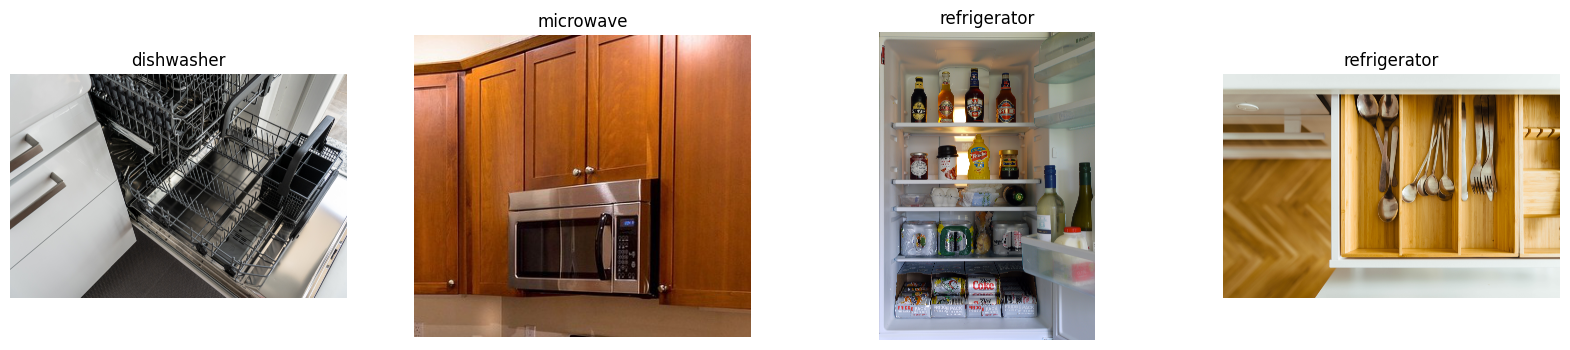

In [ ]:
#@title Visualizer
import json
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_sample_results(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Select 5 random elements from the list
    selected = random.sample(data, 4)
    
    plt.figure(figsize=(20, 4))
    for i, item in enumerate(selected):
        img = Image.open(item['file'])
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(item['label'])
        plt.axis('off')
    
    plt.show()

# Call the function with your json file
display_sample_results("./processed_results.json")

In [ ]:
import json
import pprint

os.rename("processed_results.json", "kitchen_processed_results.json")

with open('kitchen_processed_results.json') as f:
   data = json.load(f)

pprint.pprint(data)

[{'file': '/content/kitchen_images/sample1.jpg', 'label': 'dishwasher'},
 {'file': '/content/kitchen_images/sample11.jpg', 'label': 'dishwasher'},
 {'file': '/content/kitchen_images/sample7.jpeg', 'label': 'stove'},
 {'file': '/content/kitchen_images/sample2.jpg', 'label': 'refrigerator'},
 {'file': '/content/kitchen_images/sample15.jpg', 'label': 'stove'},
 {'file': '/content/kitchen_images/sample5.jpg', 'label': 'stove'},
 {'file': '/content/kitchen_images/sample10.jpg', 'label': 'dishwasher'},
 {'file': '/content/kitchen_images/sample6.jpg', 'label': 'stove'},
 {'file': '/content/kitchen_images/sample8.jpeg', 'label': 'microwave'},
 {'file': '/content/kitchen_images/sample9.jpg', 'label': 'microwave'},
 {'file': '/content/kitchen_images/sample13.jpg', 'label': 'refrigerator'},
 {'file': '/content/kitchen_images/sample12.jpg', 'label': 'dishwasher'},
 {'file': '/content/kitchen_images/sample14.jpg', 'label': 'dishwasher'},
 {'file': '/content/kitchen_images/sample3.jpg', 'label': 're

Success! 🎉

We created an agent to call the Remyx Engine to train a custom classifier, designed to annotate images saved in a specific directory.


The outcome of this process was a JSON file, encoding the mapping of files and their respective labels. This demonstration highlights the efficiency and simplicity with which complex AI inference workflows can be streamlined using just a handful of code lines.